findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not found.
findfont: Font family 'Nimbus Roman' not

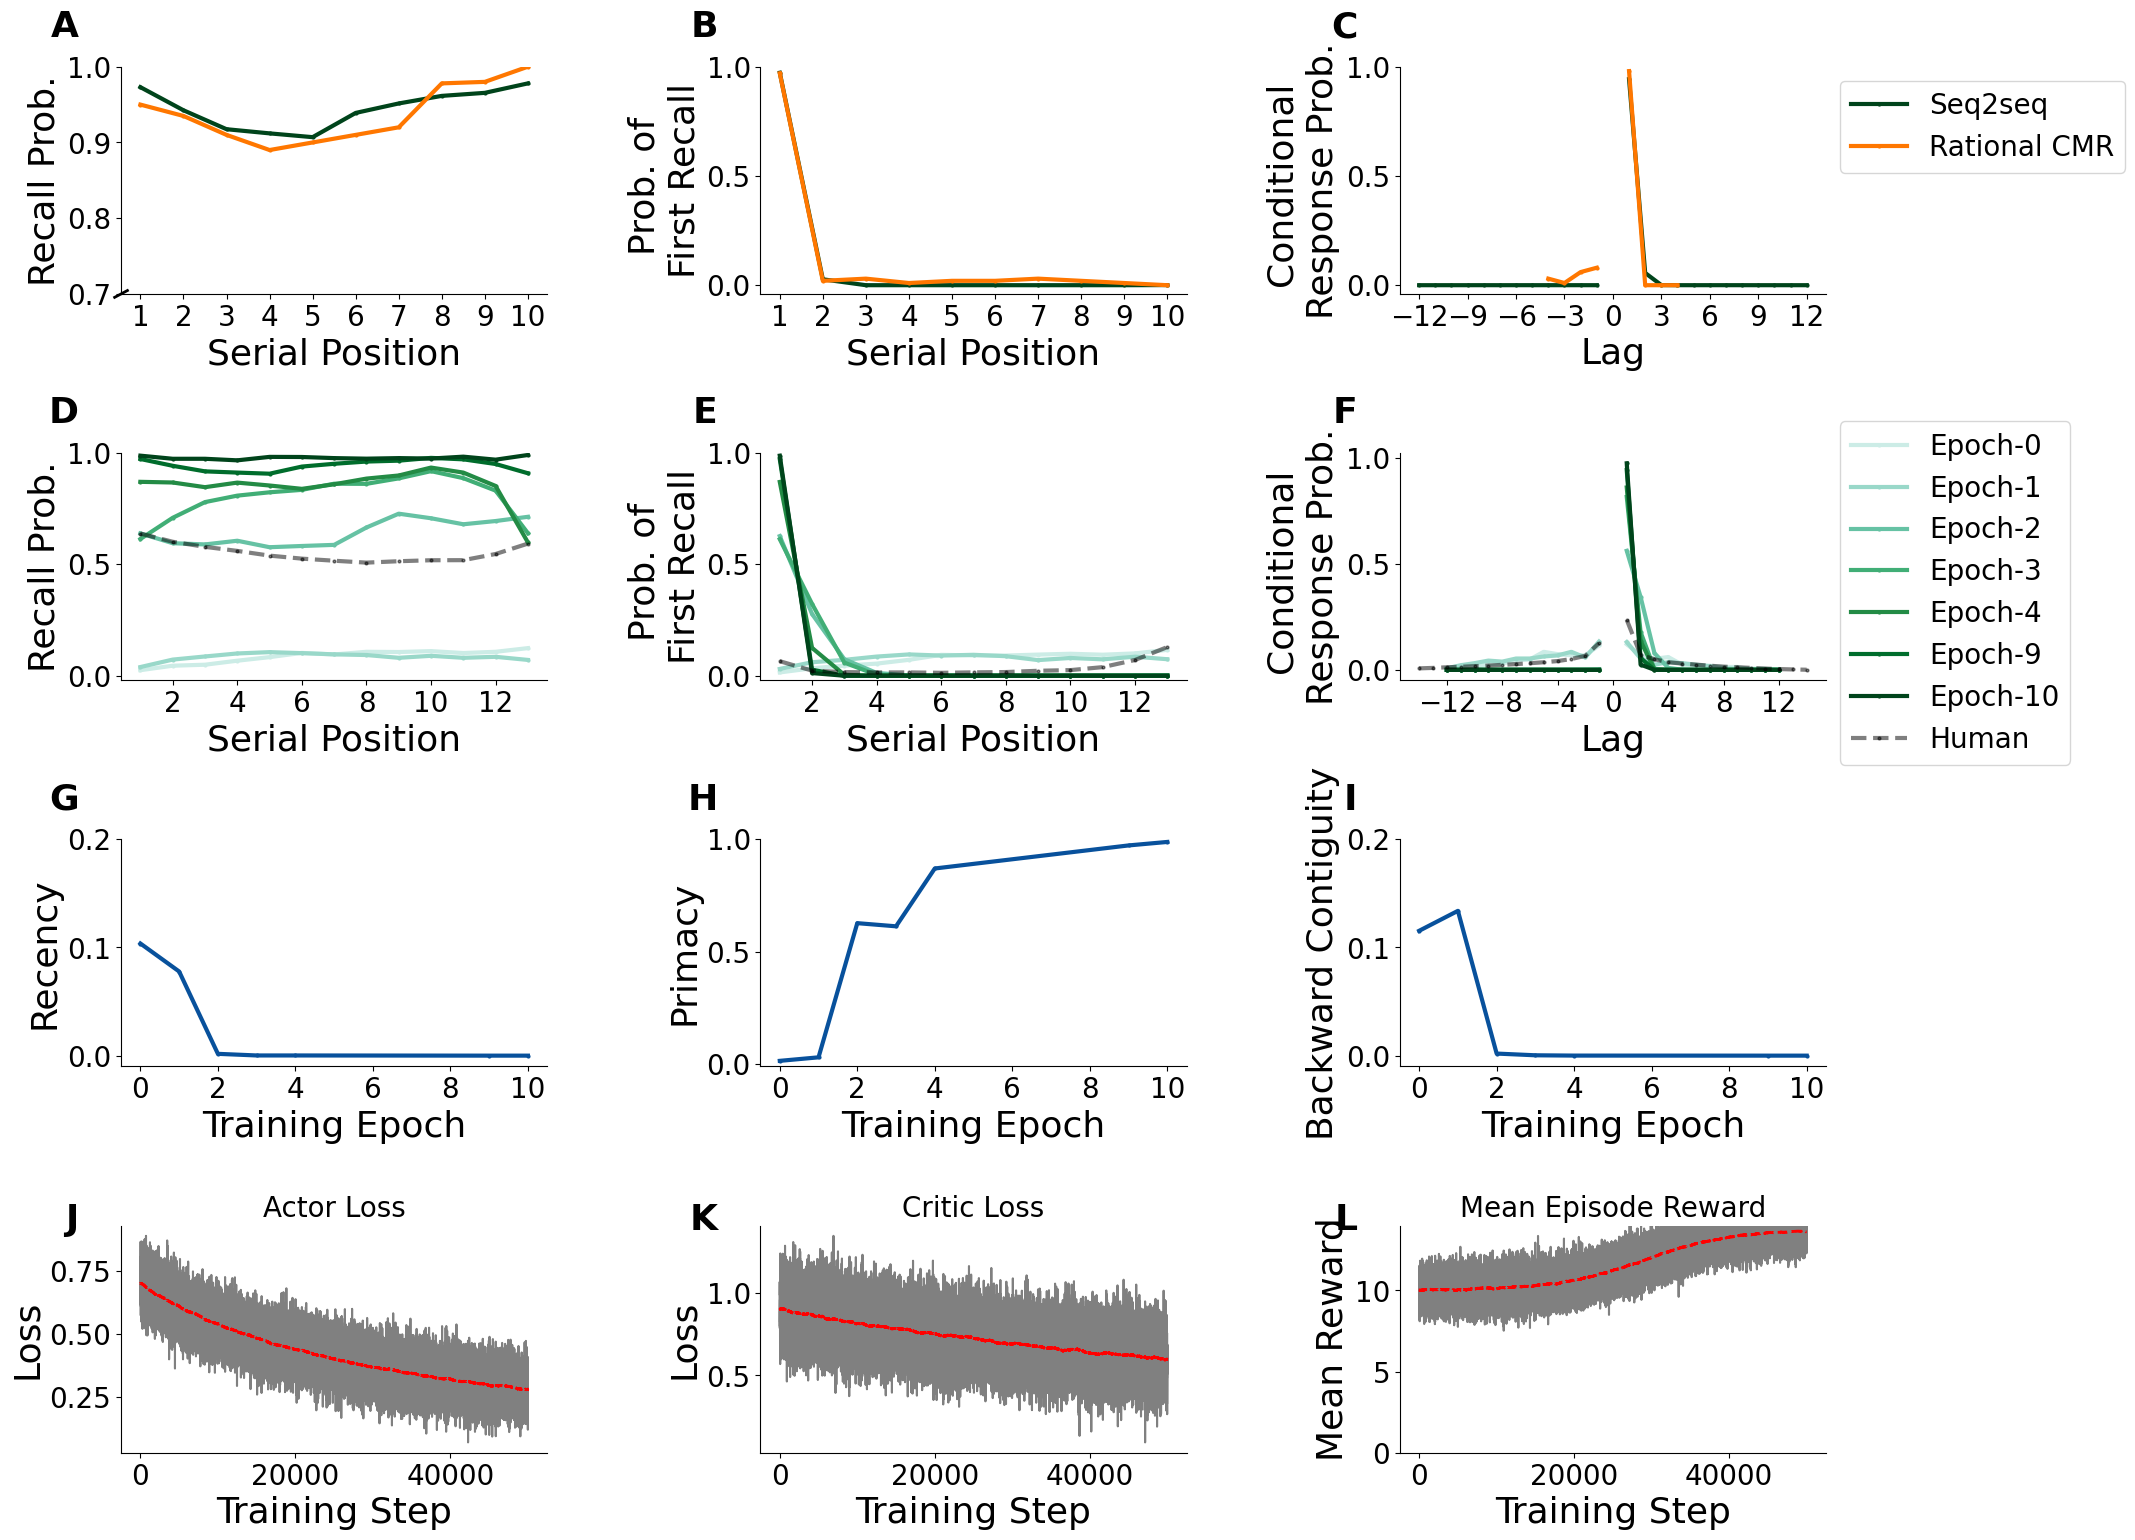

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import seaborn as sns
import pickle
import os
import re
from scipy.stats import sem
from pathlib import Path
import ipynbname

nb_path = Path(ipynbname.path())
data_path = nb_path.parent.parent

import sys
import os


sys.path.append(os.path.abspath(".."))  
sys.path.append(os.path.abspath("../.."))
from nmt_cmr_parallels.utils.evaluation_utils import (calculate_conditional_recall_probability, 
                                                  calculate_recall_probability,
                                                  calculate_first_recall_probability)

def extract_number(label):
    match = re.search(r'Epoch-(\d+)', label)
    return int(match.group(1)) if match else float('inf')

def extract_sort_keys(file_path):
    attention_type_match = re.search(r'/(Attention|NoAttention)-', file_path)
    dimension_match = re.search(r'-(\d+)Dim', file_path)

    attention_type = attention_type_match.group(1) if attention_type_match else ''
    dimension_number = int(dimension_match.group(1)) if dimension_match else 0

    return attention_type, dimension_number

bigfont = 26
smallfont = 20

fig = plt.figure(figsize=(22, 18))
plt.rcParams['font.family'] = 'Nimbus Roman'
gs = GridSpec(nrows=4, ncols=3, figure=fig)

# First Row - Optimal CMR Comparison
end_position = 11
omit_first_k = 1

filepath = data_path / "resource" / "evaluations" / "attention" / "Epoch-9.json"

with open(filepath,'r') as f:
    data = json.load(f)

if omit_first_k is not None:
    data['original_sequences'] = [x[omit_first_k:] for x in data['original_sequences']]
    data['predicted_sequences'] = [x[omit_first_k:] for x in data['predicted_sequences']]

# 1A. Serial Position Curve w/ error bars
ax = fig.add_subplot(gs[0, 0])
ax.set_xlabel('Serial Position', fontsize=bigfont)
ax.set_ylabel('Recall Prob.', fontsize=bigfont)
ax.set_ylim((0.7,1.0))
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

recall_probabilities = calculate_recall_probability(
    data['original_sequences'], data['predicted_sequences'])
label = os.path.splitext(os.path.basename(filepath))[0]
if end_position is not None:
    positions = list(range(1, end_position))
    min_length = min(len(recall_probabilities), end_position - 1)
    ax.plot(positions[:min_length], recall_probabilities[:min_length], marker='o', color="#00441b",
                linewidth=3, markersize=2, label=label)
else:
    positions = list(range(1, len(recall_probabilities) + 1))
    ax.plot(positions, recall_probabilities,
                marker='o', label=label, linewidth=3, markersize=2)
ax.plot(positions, [0.95,0.935,0.91,0.89,0.90,0.91,0.92,0.978,0.98,1.0], 
        marker='o', color="#FF7700",label="Optimal CMR", linewidth=3, markersize=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.1, 1.25, 'A', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')
d = 0.015 
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, linewidth=2)

# Draw diagonals on y-axis break
ax.plot((-d, +d), (-d, +d), **kwargs)  # bottom-left diagonal

# 1B. First Recall Probability w/ error bars
ax = fig.add_subplot(gs[0, 1])
ax.set_xlabel('Serial Position', fontsize=bigfont)
ax.set_ylabel('Prob. of \nFirst Recall', fontsize=bigfont)
ax.set_ylim((-0.04,1.0))
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

frp= calculate_first_recall_probability(
    data['original_sequences'], data['predicted_sequences'])
if end_position is not None:
    positions = list(range(1, end_position))
    min_length = min(len(frp), end_position - 1)
    ax.plot(positions[:min_length], frp[:min_length], 
                marker='o', color="#00441b", linewidth=3, markersize=2)
else:
    positions = list(range(1, len(frp) + 1))
    ax.plot(positions, frp, marker='o', linewidth=3, color="#00441b", markersize=10)

# Reproduced Optimal CMR plot from Zhang. 2021
ax.plot(positions, [0.97,0.02,0.03,0.01,0.02,0.02,0.03,0.02,0.01,0.0], 
        marker='o', color="#FF7700",label="Optimal CMR",linewidth=3, markersize=2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.1, 1.25, 'B', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')

# 1C. CRP with error bars
ax = fig.add_subplot(gs[0, 2])
ax.set_xlabel('Lag', fontsize=bigfont)
ax.set_ylabel('Conditional \nResponse Prob.', fontsize=bigfont)
ax.set_ylim((-0.04,1.0))
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

crp_probs, lags = calculate_conditional_recall_probability(data['original_sequences'], data['predicted_sequences'])
positive_lags, pos_idxs = [lag for lag in lags if lag > 0], [i for i, lag in enumerate(lags) if lag > 0]
positive_probs = [crp_probs[idx] for idx in pos_idxs]
negative_lags, neg_idxs = [lag for lag in lags if lag < 0], [i for i, lag in enumerate(lags) if lag < 0]
negative_probs = [crp_probs[idx] for idx in neg_idxs]
ax.plot(negative_lags, negative_probs, marker='o', color="#00441b", label='Seq2seq', linewidth=3, markersize=2)
ax.plot(positive_lags, positive_probs, marker='o', color='#00441b', linewidth=3, markersize=2)
ax.plot([-4,-3,-2,-1], [0.03,0.01,0.06,0.08], marker='o', color='#FF7700', label='Rational CMR', linewidth=3, markersize=2)
ax.plot([1,2,3,4], [0.98,0.0,0.0,0.0], marker='o', color='#FF7700', linewidth=3, markersize=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=smallfont)
ax.text(-0.1, 1.25, 'C', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')

# --- Intermediate curves (Row 2) ---
end_position = 14
omit_first_k = 1
reverse_colors = False
results_dir = data_path / "resource" / "evaluations" / "attention"
results_files = [str(f) for f in results_dir.iterdir() if f.suffix == ".json"]
sorted_file_paths = sorted(results_files, key=extract_number)

# 2D. Recall Probability curves with error bars for each checkpoint
ax = fig.add_subplot(gs[1, 0])
ax.set_xlabel('Serial Position', fontsize=bigfont)
ax.set_ylabel('Recall Prob.', fontsize=bigfont)
ax.set_ylim((-0.02,1.0))
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
for i, filepath in enumerate(sorted_file_paths):
    with open(filepath,'r') as f:
        data = json.load(f)
    if omit_first_k is not None:
        data['original_sequences'] = [x[omit_first_k:] for x in data['original_sequences']]
        data['predicted_sequences'] = [x[omit_first_k:] for x in data['predicted_sequences']]
    recall_probabilities = calculate_recall_probability(data['original_sequences'], data['predicted_sequences'])
    label = os.path.splitext(os.path.basename(filepath))[0]
    if end_position is not None:
        positions = list(range(1, end_position))
        min_length = min(len(recall_probabilities), end_position - 1)
        if label != 'Human Subject':
            if 'NoAttention' in filepath:
                no_attention_colors = ['#d4b9da','#c994c7','#df65b0','#e7298a','#ce1256','#980043','#67001f']
                if reverse_colors:
                    no_attention_colors = list(reversed(no_attention_colors))
                ax.plot(positions[:min_length], recall_probabilities[:min_length], marker='o', color=no_attention_colors[i], label=label, linewidth=3, markersize=2)
            else:
                attention_colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
                if reverse_colors:
                    attention_colors = list(reversed(attention_colors))
                ax.plot(positions[:min_length], recall_probabilities[:min_length], marker='o', color=attention_colors[i], label=label, linewidth=3, markersize=2)
        else:
            ax.plot(positions[:min_length], recall_probabilities[:min_length], alpha=0.5, marker='o', color='black', linestyle='--', label=label, linewidth=3, markersize=2)
    else:
        positions = list(range(1, len(recall_probabilities) + 1))
        ax.plot(positions, recall_probabilities, marker='o', linewidth=3, markersize=2)
handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda t: extract_number(t[1]))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.1, 1.25, 'D', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')

# 2E. FRP curve with error bars
ax = fig.add_subplot(gs[1, 1])
ax.set_xlabel('Serial Position',fontsize=bigfont)
ax.set_ylabel('Prob. of \nFirst Recall',fontsize=bigfont)
ax.set_ylim((-0.02,1.0))
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
for i, filepath in enumerate(sorted_file_paths):
    with open(filepath,'r') as f:
        data = json.load(f)
    if omit_first_k is not None:
        data['original_sequences'] = [x[omit_first_k:] for x in data['original_sequences']]
        data['predicted_sequences'] = [x[omit_first_k:] for x in data['predicted_sequences']]
    frp = calculate_first_recall_probability(data['original_sequences'], data['predicted_sequences'])
    label = os.path.splitext(os.path.basename(filepath))[0]
    if end_position is not None:
        positions = list(range(1, end_position))
        min_length = min(len(frp), end_position - 1)
        if label != 'Human Subject':
            if 'NoAttention' in filepath:
                no_attention_colors = ['#d4b9da','#c994c7','#df65b0','#e7298a','#ce1256','#980043','#67001f']
                if reverse_colors:
                    no_attention_colors = list(reversed(no_attention_colors))
                ax.plot(positions[:min_length], frp[:min_length],
                            marker='o', color=no_attention_colors[i], label=label, linewidth=3, markersize=2)
            else:
                attention_colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
                if reverse_colors:
                    attention_colors = list(reversed(attention_colors))
                ax.plot(positions[:min_length], frp[:min_length],
                            marker='o', color=attention_colors[i], label=label, linewidth=3, markersize=2)
        else:
            ax.plot(positions[:min_length], frp[:min_length],
                        marker='o', alpha=0.5, color='black', linestyle='--',label=label, linewidth=3, markersize=2)
    else:
        positions = list(range(1, len(frp) + 1))
        ax.plot(positions, frp, alpha=0.5, marker='o', label=label)
handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda t: extract_number(t[1]))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.1, 1.25, 'E', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')

# 2F. CRP curves with error bars for each checkpoint
ax = fig.add_subplot(gs[1, 2])
ax.set_xlabel('Lag',fontsize=bigfont)
ax.set_ylabel('Conditional \nResponse Prob.',fontsize=bigfont)
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
for i,filepath in enumerate(sorted_file_paths):
    with open(filepath,'r') as f:
        data = json.load(f)
    if omit_first_k is not None:
        data['original_sequences'] = [x[omit_first_k:] for x in data['original_sequences']]
        data['predicted_sequences'] = [x[omit_first_k:] for x in data['predicted_sequences']]
    crp_probs, lags = calculate_conditional_recall_probability(
        data['original_sequences'], data['predicted_sequences'])
    positive_lags, pos_idxs = [lag for lag in lags if lag > 0], [i for i, lag in enumerate(lags) if lag > 0]
    positive_probs = [crp_probs[idx] for idx in pos_idxs]
    negative_lags, neg_idxs = [lag for lag in lags if lag < 0], [i for i, lag in enumerate(lags) if lag < 0]
    negative_probs = [crp_probs[idx] for idx in neg_idxs]
    label = os.path.splitext(os.path.basename(filepath))[0]
    if label != 'Human Subject':
        if 'NoAttention' in filepath:
            no_attention_colors = ['#d4b9da','#c994c7','#df65b0','#e7298a','#ce1256','#980043','#67001f']
            if reverse_colors:
                no_attention_colors = list(reversed(no_attention_colors))
            ax.plot(negative_lags, negative_probs, marker='o', color=no_attention_colors[i], label=label, linewidth=3, markersize=2)
            ax.plot(positive_lags, positive_probs, marker='o', color=no_attention_colors[i], linewidth=3, markersize=2)
        else:
            attention_colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
            if reverse_colors:
                attention_colors = list(reversed(attention_colors))
            ax.plot(negative_lags, negative_probs, marker='o', color=attention_colors[i], label=label, linewidth=3, markersize=2)
            ax.plot(positive_lags, positive_probs, marker='o', color=attention_colors[i], linewidth=3, markersize=2)
    else:
        ax.plot(positive_lags, positive_probs, marker='o', color='black',linestyle='--',linewidth=3, alpha=0.5, markersize=2)
        ax.plot(negative_lags, negative_probs, marker='o', color='black', linestyle='--',label=label, alpha=0.5,linewidth=3, markersize=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, labels = plt.gca().get_legend_handles_labels()
labels[7]="Human"
ax.legend(handles, labels,loc='upper left', bbox_to_anchor=(1, 1.2),fontsize=smallfont)
ax.text(-0.1, 1.25, 'F', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')

# Recency, Primacy, Backward Contiguity
attention_files = [os.path.join(results_dir, x) for x in os.listdir(results_dir) if x.endswith('.json') and 'Human' not in x]

# 3G. Recency: mean and error across last 3 serial positions
ax = fig.add_subplot(gs[2, 0])
omit_first_k = 1
recency_metric, recency_sem = [], []
for filepath in attention_files:
    with open(filepath, 'r') as f:
        results = json.load(f)
    if omit_first_k > 0:
        results['original_sequences'] = [x[omit_first_k:] for x in results['original_sequences']]
        results['predicted_sequences'] = [x[omit_first_k:] for x in results['predicted_sequences']]
    frp = calculate_first_recall_probability(results['original_sequences'], results['predicted_sequences'])
    recency_vals = frp[-3:]
    recency_metric.append((extract_number(filepath), np.mean(recency_vals)))
recency_metric = sorted(recency_metric, key=lambda x: x[0])
recency_sem = sorted(recency_sem, key=lambda x: x[0])
epochs = [x[0] for x in recency_metric]
recency_metric_vals = [x[1] for x in recency_metric]
recency_sem_vals = [x[1] for x in recency_sem]
ax.set_ylabel('Recency', fontsize=bigfont)
ax.set_ylim((-0.01,0.2))
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.plot(epochs, recency_metric_vals, marker='o', color="#08519c", linewidth=3, markersize=2)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Training Epoch',fontsize=bigfont)
ax.text(-0.1, 1.25, 'G', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')

# 3H. Primacy: mean and error of first position
ax = fig.add_subplot(gs[2, 1])
omit_first_k = 1
primacy_metric, primacy_sem = [], []
for filepath in attention_files:
    with open(filepath, 'r') as f:
        results = json.load(f)
    if omit_first_k > 0:
        results['original_sequences'] = [x[omit_first_k:] for x in results['original_sequences']]
        results['predicted_sequences'] = [x[omit_first_k:] for x in results['predicted_sequences']]
    frp = calculate_first_recall_probability(results['original_sequences'], results['predicted_sequences'])
    primacy_metric.append((extract_number(filepath), frp[0]))
primacy_metric = sorted(primacy_metric, key=lambda x: x[0])
primacy_sem = sorted(primacy_sem, key=lambda x: x[0])
epochs = [x[0] for x in primacy_metric]
primacy_metric_vals = [x[1] for x in primacy_metric]
primacy_sem_vals = [x[1] for x in primacy_sem]
ax.set_ylabel('Primacy', fontsize=bigfont)
ax.set_ylim((-0.01,1.0))
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.plot(epochs, primacy_metric_vals, marker='o', color="#08519c", linewidth=3, markersize=2)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Training Epoch',fontsize=bigfont)
ax.text(-0.1, 1.25, 'H', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')

# 3I. Backward Contiguity: mean and error of lag -1
ax = fig.add_subplot(gs[2, 2])
omit_first_k = 1
backcont, backcont_sem = [], []
for filepath in attention_files:
    with open(filepath, 'r') as f:
        results = json.load(f)
    if omit_first_k > 0:
        results['original_sequences'] = [x[omit_first_k:] for x in results['original_sequences']]
        results['predicted_sequences'] = [x[omit_first_k:] for x in results['predicted_sequences']]
    probs, lags = calculate_conditional_recall_probability(results['original_sequences'], results['predicted_sequences'])
    neg1_index = lags.index(-1)
    backcont.append((extract_number(filepath), probs[neg1_index]))
backcont = sorted(backcont, key=lambda x: x[0])
backcont_sem = sorted(backcont_sem, key=lambda x: x[0])
epochs = [x[0] for x in backcont]
backcont_vals = [x[1] for x in backcont]
ax.set_ylabel('Backward Contiguity', fontsize=bigfont)
ax.set_ylim((-0.01,0.2))
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.plot(epochs, backcont_vals, marker='o', color="#08519c", linewidth=3, markersize=2)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Training Epoch',fontsize=bigfont)
ax.text(-0.1, 1.25, 'I', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')

datafile = "rl_training_results.pkl"

# Add RL training results as fourth row (J, K, L)
rl_row = 3

steps = np.arange(1, 50_001)
rl_data_struct = {
    "actor_loss" : [],
    "actor_loss_mean": [],
    "critic_loss": [],
    "critic_loss_mean": [],
    "mean_reward": [],
    "mean_reward_mean": []
}
with open(datafile, "rb") as f:
    rl_data_struct = pickle.load(f)

# J. Actor Loss
ax = fig.add_subplot(gs[rl_row, 0])
ax.plot(steps, rl_data_struct["actor_loss"], color='0.5', label='Actor Loss')
ax.plot(steps, rl_data_struct["actor_loss_mean"], 'r--', linewidth=2, label='Mean')
ax.set_xlabel("Training Step", fontsize=bigfont)
ax.set_ylabel("Loss", fontsize=bigfont)
ax.set_title("Actor Loss", fontsize=smallfont)
ax.tick_params(axis='both', labelsize=smallfont)
ax.text(-0.1, 1.1, 'J', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# K. Critic Loss
ax = fig.add_subplot(gs[rl_row, 1])
ax.plot(steps, rl_data_struct["critic_loss"], color='0.5', label='Critic Loss')
ax.plot(steps, rl_data_struct["critic_loss_mean"], 'r--', linewidth=2, label='Mean')
ax.set_xlabel("Training Step", fontsize=bigfont)
ax.set_ylabel("Loss", fontsize=bigfont)
ax.set_title("Critic Loss", fontsize=smallfont)
ax.tick_params(axis='both', labelsize=smallfont)
ax.text(-0.1, 1.1, 'K', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# L. Mean Reward
ax = fig.add_subplot(gs[rl_row, 2])
ax.plot(steps, rl_data_struct["mean_reward"], color='0.5', label='Mean Reward')
ax.plot(steps, rl_data_struct["mean_reward_mean"], 'r--', linewidth=2, label='Mean')
ax.set_xlabel("Training Step", fontsize=bigfont)
ax.set_ylabel("Mean Reward", fontsize=bigfont)
ax.set_title("Mean Episode Reward", fontsize=smallfont)
#ax.set_ylim([np.min(mean_reward), 14])
ax.set_ylim([0, 14])
ax.tick_params(axis='both', labelsize=smallfont)
ax.text(-0.1, 1.1, 'L', transform=ax.transAxes, fontsize=bigfont, fontweight='bold', va='top', ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplots_adjust(hspace=0.7, wspace=0.5)
plt.show()
